In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-movie-recommendation-predict/sample_submission.csv
/kaggle/input/edsa-movie-recommendation-predict/movies.csv
/kaggle/input/edsa-movie-recommendation-predict/imdb_data.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_tags.csv
/kaggle/input/edsa-movie-recommendation-predict/genome_scores.csv
/kaggle/input/edsa-movie-recommendation-predict/train.csv
/kaggle/input/edsa-movie-recommendation-predict/test.csv
/kaggle/input/edsa-movie-recommendation-predict/tags.csv
/kaggle/input/edsa-movie-recommendation-predict/links.csv


In [2]:
path = "/kaggle/input/edsa-movie-recommendation-predict/sample_submission.csv"
sample_submission = pd.read_csv(path)
sample_submission.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [3]:
#Pip installations
!pip install scikit-surprise

In [4]:
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans 
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

In [5]:
df_train = pd.read_csv('../input/edsa-movie-recommendation-predict/train.csv')
df_test = pd.read_csv('../input/edsa-movie-recommendation-predict/test.csv')
df_genome_scores = pd.read_csv('../input/edsa-movie-recommendation-predict/genome_scores.csv')
df_genome_tags = pd.read_csv('../input/edsa-movie-recommendation-predict/genome_tags.csv')
df_imdb_data = pd.read_csv('../input/edsa-movie-recommendation-predict/imdb_data.csv')
df_movies = pd.read_csv('../input/edsa-movie-recommendation-predict/movies.csv')
df_tags = pd.read_csv('../input/edsa-movie-recommendation-predict/tags.csv')
df_links = pd.read_csv('../input/edsa-movie-recommendation-predict/links.csv')

df_train.head()
df_test.head()
df_genome_scores.head()
df_genome_tags.head()
df_imdb_data.head()
df_movies.head()
df_tags.head()
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
#replace missings in imdb data
df_imdb_data['title_cast'] = df_imdb_data['title_cast'].fillna('')
df_imdb_data['director'] = df_imdb_data['director'].fillna('')
df_imdb_data['budget'] = df_imdb_data['budget'].fillna('')
df_imdb_data['runtime'] = df_imdb_data['runtime'].fillna(0)

#replace missings in links
df_links['tmdbId'] = df_links['tmdbId'].fillna(0)

#replace missings in tags
df_tags['tag'] = df_tags['tag'].fillna('')

In [7]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


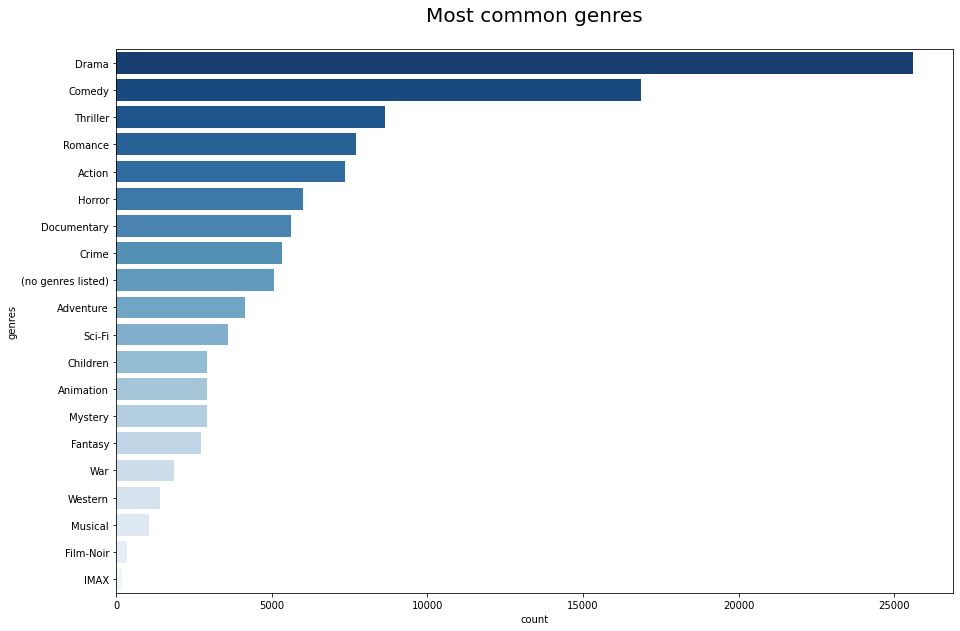

In [8]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Blues_r')
plt.show()

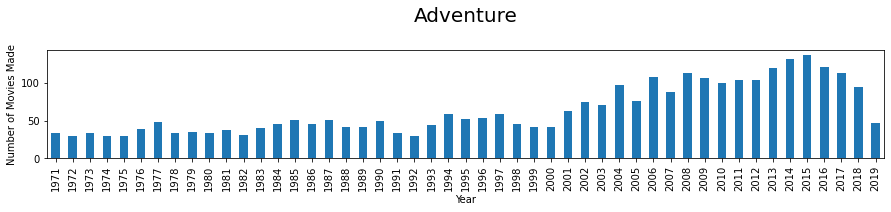

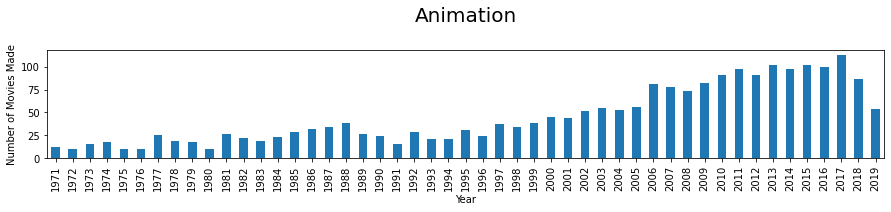

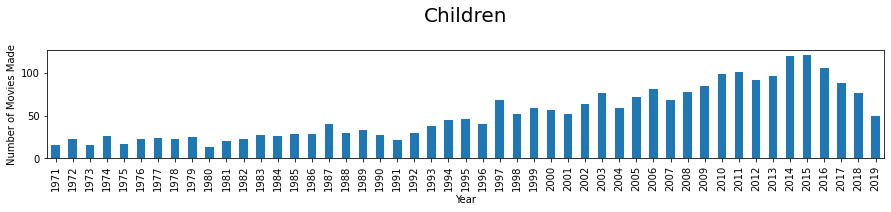

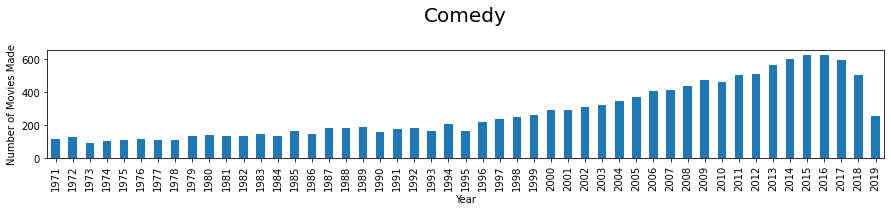

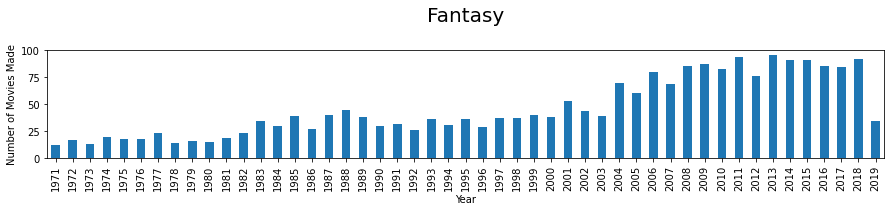

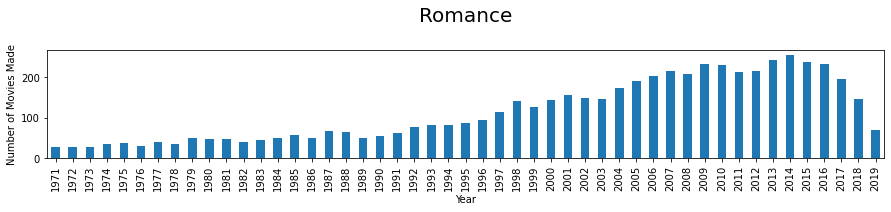

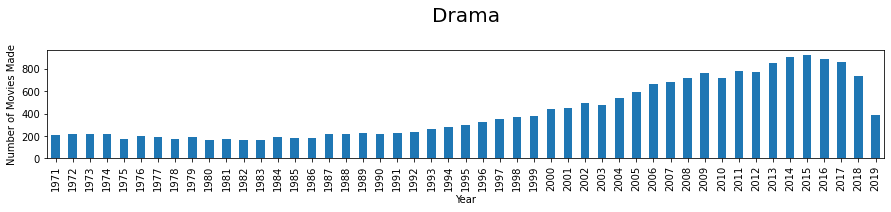

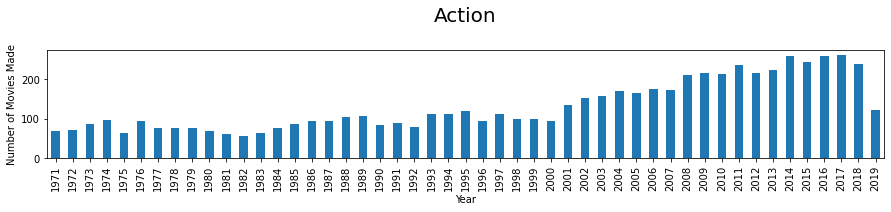

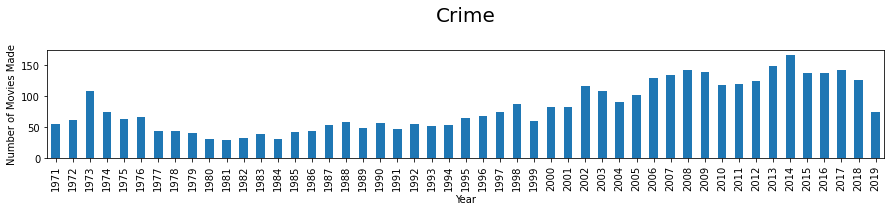

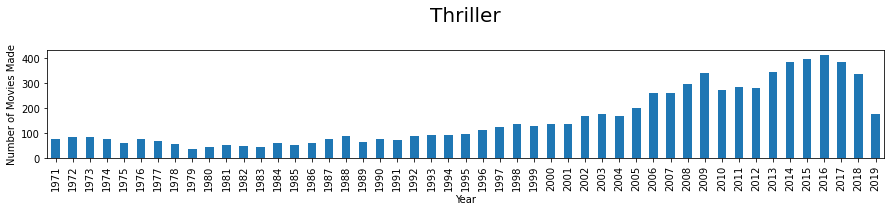

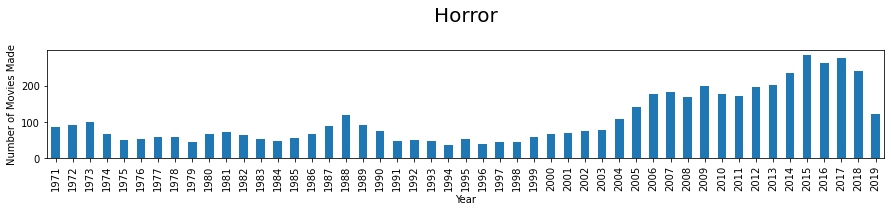

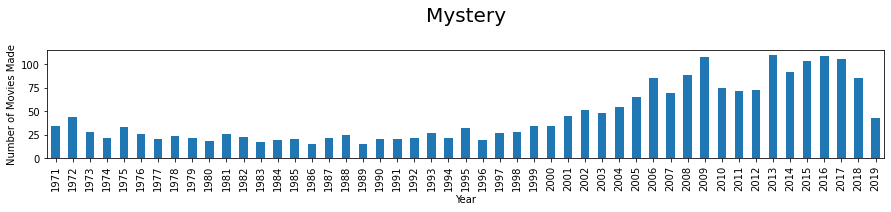

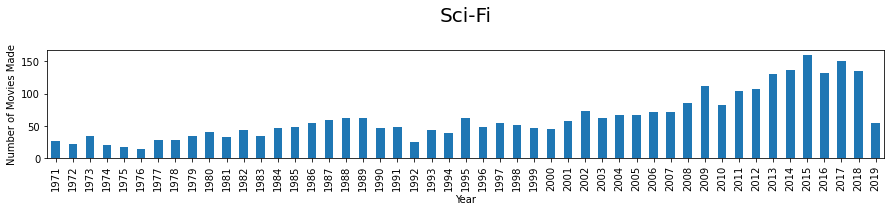

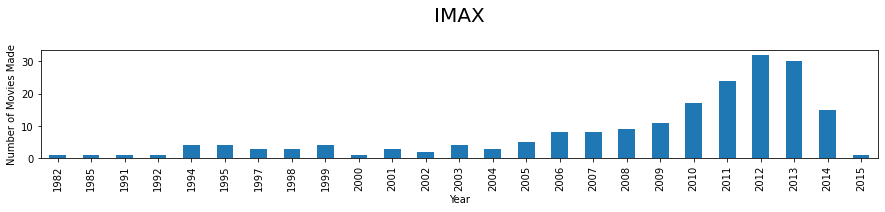

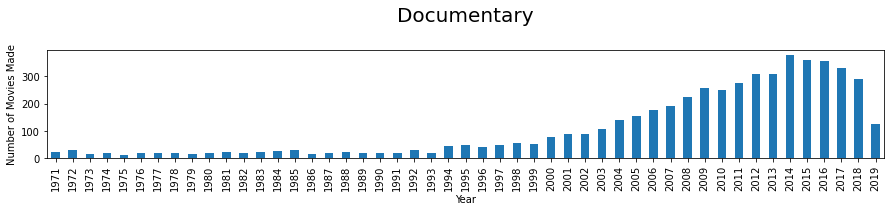

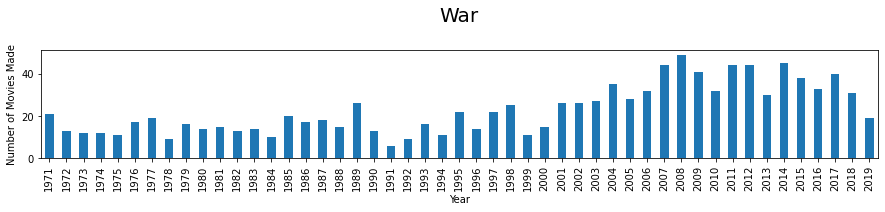

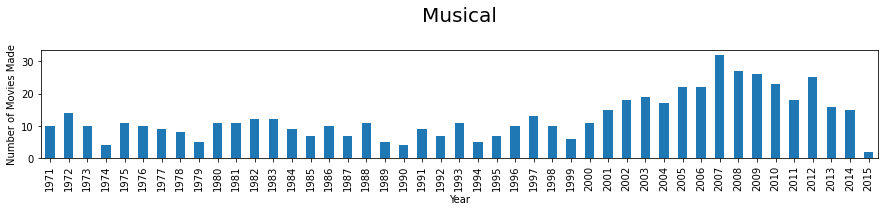

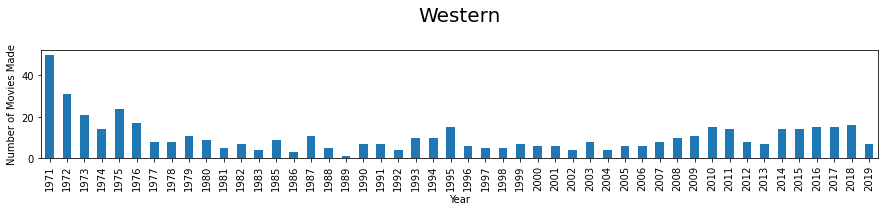

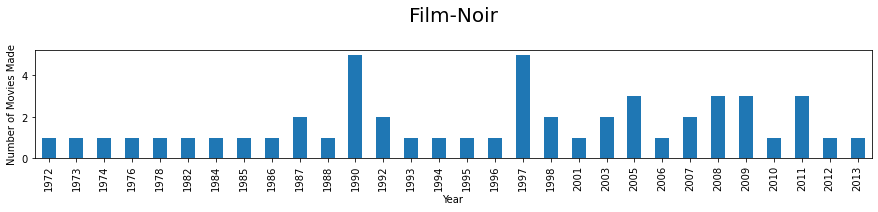

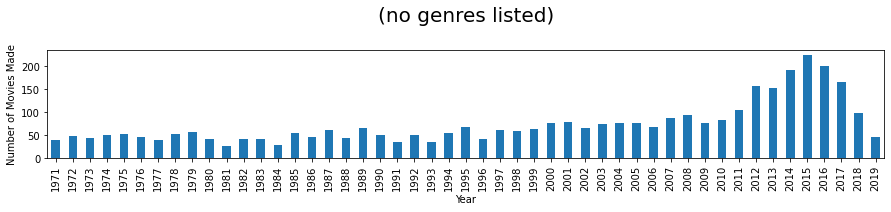

In [9]:
# Add a 'year' column to the movies dataframe that contains the release year of each movie (if available)
years = df_movies.title.apply(lambda x: re.findall(r'\((.[\d]+)\)', x))
df_movies['year'] = years.str[-1]

# Create a dataframe containing the year and genres for each movie
genres_per_year = pd.merge(movies_genres, df_movies[['movieId', 'year']], on='movieId', how='left')

# Create a list containing all the unique genres present in the dataframe
unique_genres = list(movies_genres.genres.unique())

# Plot the number of movies released under each genre from 1970 until 2019
for genre in unique_genres:
    plot = plt.figure(figsize=(15, 2))
    plt.xlabel('Year')
    plt.ylabel('Number of Movies Made')
    plt.title(f'{genre}\n', fontsize=20)
    genres_per_year[genres_per_year.genres == genre][genres_per_year.year.astype(float)
                                                    > 1970].year.value_counts().sort_index().plot(kind='bar',
                                                                                                color='tab:blue')

plt.show()

In [10]:
# Create list containing the counts
# for each tag in the tags dataframe and sort in descending order of counts
tag_counts = df_tags['tag'].value_counts(ascending=False)
# Create dataframe showing the top 10 most common tags and their counts
most_common_tags = list(zip(tag_counts[:10].index, tag_counts[:10]))
most_common_tags = pd.DataFrame(most_common_tags)
most_common_tags.columns = ['tag', 'count']
most_common_tags.style.background_gradient(cmap='Blues')

,tag,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326
5,based on a book,5079
6,twist ending,4820
7,funny,4738
8,visually appealing,4526
9,dystopia,4257


In [11]:
# Create a list containing the number of tags per movie
freq_list = list(df_tags.movieId.value_counts())

# Determine the most common number of tags per movie
highest_freq = max(set(freq_list), key=freq_list.count)

# Find the ratio of movies containg the most common number of tags
ratio = round((list(tag_counts).count(1)/len(tag_counts))*100, 0)

# Find the movie title that has the most tags
max_freq_name = df_movies.title[df_movies.movieId == df_tags.movieId.value_counts(ascending=False).index[0]].values[0]

# Display findings
print(f'Most movies ({ratio}%) have {highest_freq} tag(s)\n')
print(f'{max_freq_name} has the maximum number of {max(freq_list)} tags')

Most movies (49.0%) have 1 tag(s)

Star Wars: Episode IV - A New Hope (1977) has the maximum number of 6180 tags


In [12]:
# Find the movies that only have one significantly relevant tag and determine the count of the tags present
c_rel = df_genome_scores[df_genome_scores.relevance == df_genome_scores.relevance.max()].tagId.value_counts(ascending=False)
print(f'Relevance scores of the tags: {df_genome_scores.relevance.max()}')

# Create a dataframe containing the top 10 tags that containg the most relevance to their movies and their counts
c_rel_tags = list(zip(df_genome_tags.tag[list(c_rel[:10].index-1)], c_rel[:10]))
complete_relevance = pd.DataFrame(c_rel_tags)
complete_relevance.columns = ['tag', 'count']
complete_relevance.style.background_gradient(cmap='Blues')

Relevance scores of the tags: 1.0


,tag,count
0,007 (series),18
1,martial arts,10
2,aardman studios,8
3,view askew,7
4,time loop,5
5,goretastic,5
6,android(s)/cyborg(s),5
7,tom clancy,4
8,author:alan moore,4
9,vampire human love,4


In [13]:
print('In our dataset there are \033[1m{}\033[0m number of users in the dataset,'.format(len(df_train['userId'].unique())))
print('with a total of \033[1m{}\033[0m movies rated.'.format(len(df_train['movieId'].unique())))

In our dataset there are 162541 number of users in the dataset,
with a total of 48213 movies rated.


In [14]:
# Total ratings per user and their average ratings
users = df_train.groupby('userId').agg(num_ratings=('movieId', 'size'),
                                       average_rating=('rating', 'mean')).reset_index()

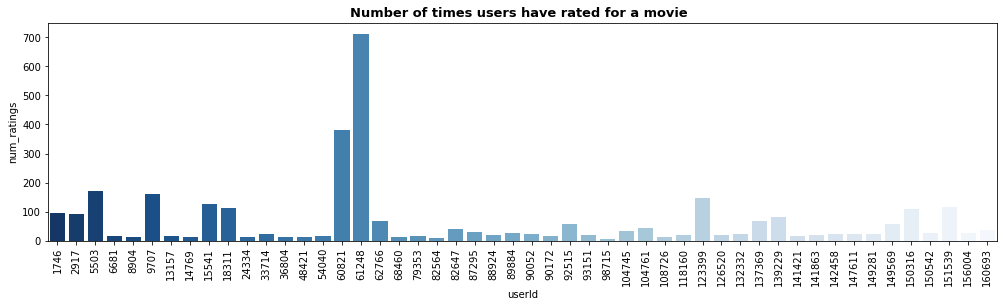

In [15]:
# Total number of ratings for each user looking at 50 users. each user on x-axis, total rating on y
plot = plt.figure(figsize=(17, 4))
plt.figtext(.51, .85, 'Number of times users have rated for a movie\n', fontsize=13, ha='center', fontweight='bold')
sns.barplot(x='userId', y='num_ratings',
            data=users.sample(n=50, random_state=62).sort_values('num_ratings'), palette='Blues_r')
plt.xticks(rotation='vertical')

plt.show()

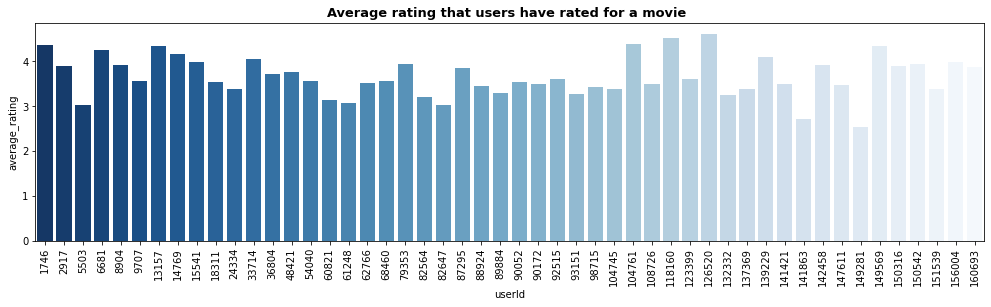

In [16]:
# Average rating for each user looking at 50 users. Each user on x-axis, average rating on y
plot = plt.figure(figsize=(17, 4))
plt.figtext(.51, .85, 'Average rating that users have rated for a movie\n',
            fontsize=13, ha='center', fontweight='bold')
sns.barplot(x='userId', y='average_rating',
            data=users.sample(n=50, random_state=62).sort_values('num_ratings'), palette='Blues_r')
plt.xticks(rotation='vertical')

plt.show()

In [17]:
df_train['rating'].describe().apply(lambda x: format(x, 'f'))

count    10000038.000000
mean            3.533395
std             1.061124
min             0.500000
25%             3.000000
50%             3.500000
75%             4.000000
max             5.000000
Name: rating, dtype: object

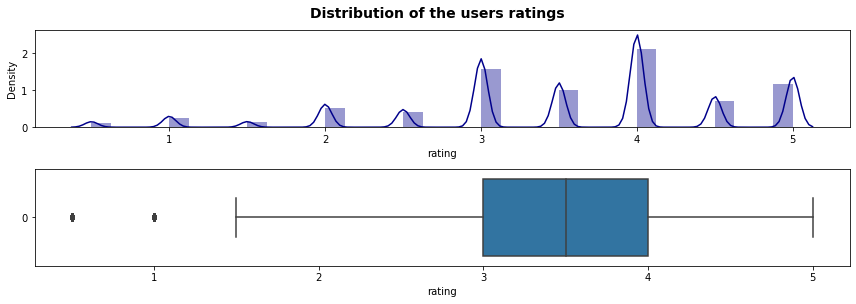

In [18]:
# Distribution of users rating
plot, axes = plt.subplots(2, 1, figsize=(12, 4))
plt.figtext(.51, .95, 'Distribution of the users ratings\n',
            fontsize=14, ha='center', fontweight='bold')

sns.distplot(df_train['rating'], hist=True, kde=True,
             bins=int(180/5), color='darkblue', ax=axes[0])

sns.boxplot(data=df_train['rating'],  orient='h', ax=axes[1])
plt.xlabel('rating')

plt.tight_layout()
plt.show()

In [19]:
users['average_rating'].describe()

count    162541.000000
mean          3.678923
std           0.506977
min           0.500000
25%           3.376404
50%           3.701493
75%           4.000000
max           5.000000
Name: average_rating, dtype: float64

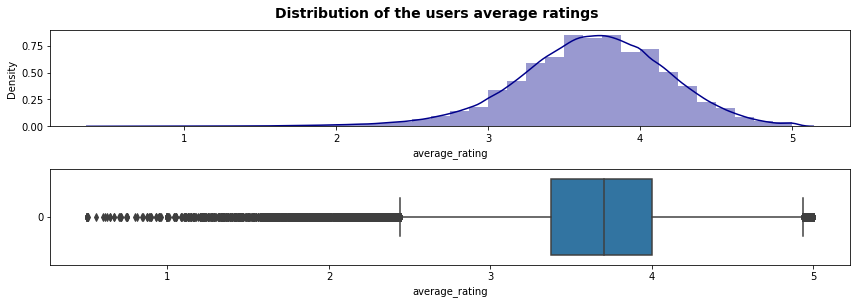

In [20]:
# Distribution of users rating
plot, axes = plt.subplots(2, 1, figsize=(12, 4))
plt.figtext(.51, .95, 'Distribution of the users average ratings\n', fontsize=14, ha='center',
            fontweight='bold')
sns.distplot(users['average_rating'], hist=True, kde=True,
             bins=int(180/5), color='darkblue', ax=axes[0])

sns.boxplot(data=users['average_rating'],  orient='h', ax=axes[1])
plt.xlabel('average_rating')

plt.tight_layout()
plt.show()

In [21]:
users.describe()

,userId,num_ratings,average_rating
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,61.523173,3.678923
std,46921.68939,107.410889,0.506977
min,1.00000,1.000000,0.500000
25%,40636.00000,14.000000,3.376404
50%,81271.00000,28.000000,3.701493
75%,121906.00000,65.000000,4.000000
max,162541.00000,12952.000000,5.000000


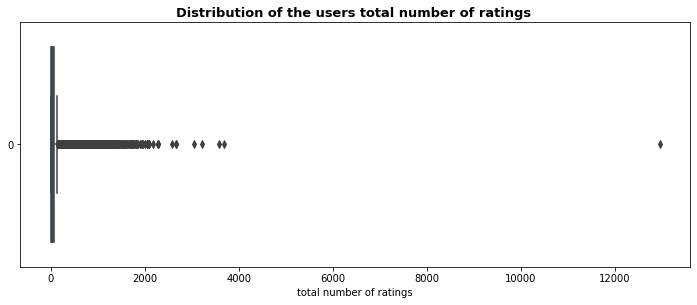

In [22]:
# Distribution of users rating
plot = plt.subplots(figsize=(12, 4.5))
plt.figtext(.51, .85, 'Distribution of the users total number of ratings\n',
            fontsize=13, ha='center', fontweight='bold')

sns.boxplot(data=users['num_ratings'],  orient='h')
plt.xlabel('total number of ratings', fontsize=10)

plt.show()

In [23]:
print('The largest value in the total ratings is \033[1m{}\033[0m'.format(users['num_ratings'].max()))
print('but the 2nd largest value is \033[1m{}\033[0m'.format(users['num_ratings'].sort_values().iloc[-2]))
print('The largest value is \033[1m{}\033[0m times more than the second largest value'\
      .format(round(users['num_ratings'].max()/users['num_ratings'].sort_values().iloc[-2], 2)))

The largest value in the total ratings is 12952
but the 2nd largest value is 3680
The largest value is 3.52 times more than the second largest value


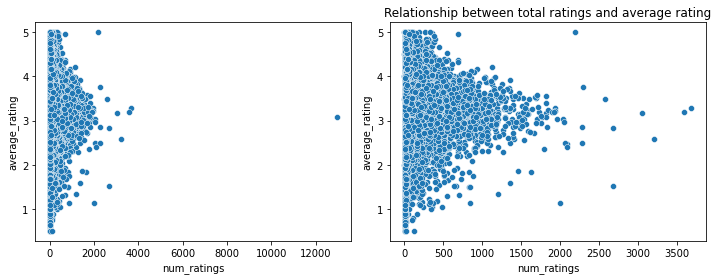

In [24]:
# Scatter plot of total rating vs average rating
plot, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.title('Relationship between total ratings and average rating', fontsize=12)

sns.scatterplot(x=users['num_ratings'], y=users['average_rating'], data=users, ax=axes[0])

sns.scatterplot(x=users['num_ratings'][users['num_ratings'] != 12952],
                y=users['average_rating'][users['num_ratings'] != 12952], data=users, ax=axes[1])

plt.tight_layout()
plt.show()

In [25]:
# Create dataframe containing only the movieId and titles
movies_titles = pd.DataFrame(df_movies[['movieId', 'title']],
                             columns=['movieId', 'title'])

In [26]:
# Create dataframe with combination of ratings and movies

movie_avg_ratings = df_train.groupby('movieId').agg(total_movies_rated=('movieId', 'size'),
                                                      average_rating=('rating', 'mean')).reset_index()
movie_avg_ratings = movie_avg_ratings.sort_values(['average_rating',
                                                   'total_movies_rated'], ascending=False)
movies_and_ratings = pd.merge(movie_avg_ratings,
                              movies_titles, on='movieId', how='left')                                                   
movies_and_ratings = pd.merge(movie_avg_ratings, movies_titles,
                              on='movieId', how='left')
years = movies_and_ratings.title.apply(lambda x: re.findall(r'\((.[\d]+)\)', x))
movies_and_ratings['year'] = years.str[-1]

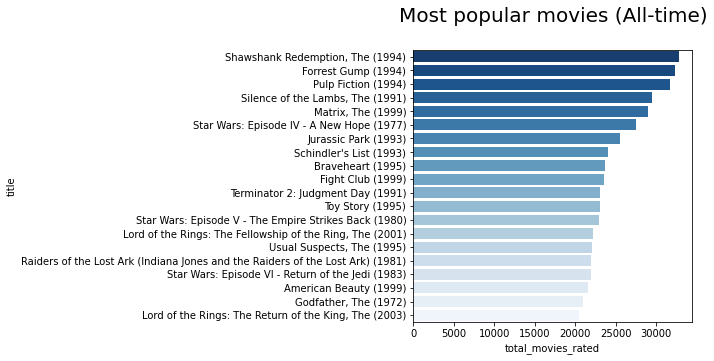

In [27]:
# Plot of the movies with the most ratings
movie_plot = plt.figure(figsize=(5, 5))
plt.title('Most popular movies (All-time)\n', fontsize=20)
sns.barplot(x='total_movies_rated', y='title',
            data=movies_and_ratings.sort_values('total_movies_rated',
                                                ascending=False)[0:20], palette='Blues_r')
plt.show()

In [28]:
# Segment the movies by popularity
most_pop_movies = movies_and_ratings[movies_and_ratings['total_movies_rated'] >= 10000]
least_pop_movies = movies_and_ratings[movies_and_ratings['total_movies_rated'] < 10000]
mildly_popular_movies = least_pop_movies[movies_and_ratings['total_movies_rated'] > 5000]

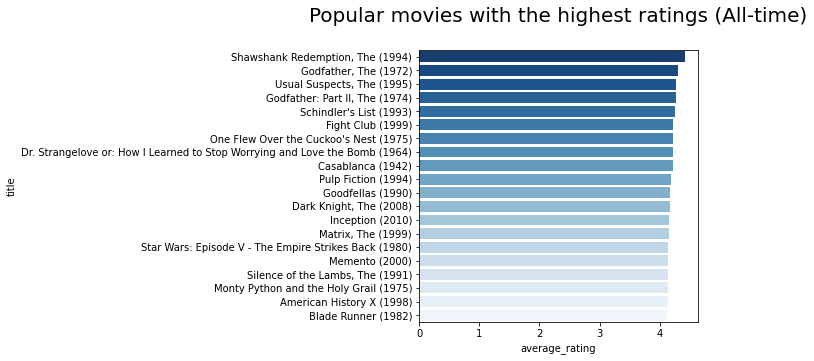

In [29]:
movie_plot = plt.figure(figsize=(5, 5))
plt.title('Popular movies with the highest ratings (All-time)\n', fontsize=20)
sns.barplot(x='average_rating', y='title',
            data=most_pop_movies.sort_values('average_rating',
                                             ascending=False)[0:20], palette='Blues_r')
plt.show()

In [30]:
# Add the movie lenghts to the dataframe of interest
movies_and_ratings = pd.merge(movie_avg_ratings,
                              df_imdb_data[['movieId', 'runtime']],
                              on='movieId', how='left')

movies_and_ratings_RT = movies_and_ratings.dropna()

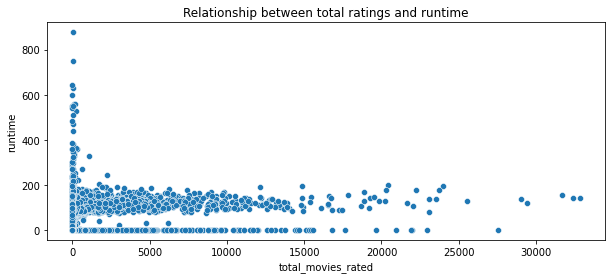

In [31]:
# Use a scatter plot to view the relationship between movie length and rating
plot = plt.figure(figsize=(10, 4))
plt.title('Relationship between total ratings and runtime', fontsize=12)

sns.scatterplot(x=movies_and_ratings_RT['total_movies_rated'],
                y=movies_and_ratings_RT['runtime'], data=movies_and_ratings_RT)
plt.show()

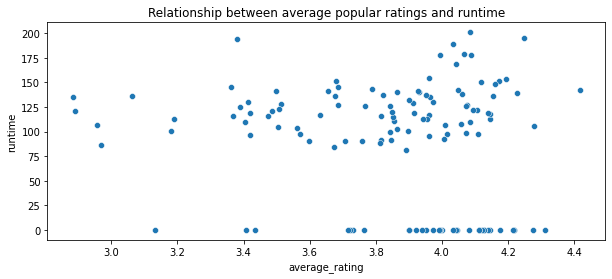

In [32]:
movies_and_ratings_RT = movies_and_ratings_RT[movies_and_ratings_RT['total_movies_rated'] >= 10000]
plot = plt.figure(figsize=(10, 4))
plt.title('Relationship between average popular ratings and runtime', fontsize=12)

sns.scatterplot(x=movies_and_ratings_RT['average_rating'],
                y=movies_and_ratings_RT['runtime'], data=movies_and_ratings_RT)
plt.show()

In [33]:
# Create new dataframe we taking a subsample due to the size of the data
df_train_adj = df_train.sample(n=10000, random_state=777)
df_train_adj.shape

(10000, 4)

In [34]:
print(f'Number of observations in the original training dataset: {len(df_train)}')
print(f'Number of observations in the adjusted training dataset: {len(df_train_adj)}')

Number of observations in the original training dataset: 10000038
Number of observations in the adjusted training dataset: 10000


In [35]:
# Specify the range of rating values
reader_eval = Reader(rating_scale=(0, 5))

# Create the train dataset
data_eval = Dataset.load_from_df(df_train.drop(['timestamp'], axis=1).sample(frac = 0.01, random_state = 777), reader_eval)

In [36]:
# Create list to contain evaluation metrics
evaluation = []

# Create list with model names and objects
model_list = [('SVD',SVD()), ('SVDpp',SVDpp()), ('NMF',NMF()), ('SlopeOne',SlopeOne()), ('CoClustering',CoClustering())]

# Iterate over all algorithms
for model in model_list:
    # Evaluate metric(s) by cross-validation
    results = cross_validate(model[1], data_eval, measures=['RMSE'], cv=3, verbose=False)
    
    #Append algorithm name and evaluation results to list
    x = pd.DataFrame.from_dict(results).mean(axis=0)
    x = x.append(pd.Series(model[0], index=['model']))
    evaluation.append(x)
    
# Output results as dataframe
pd.DataFrame(evaluation).set_index('model').sort_values('test_rmse') 

,test_rmse,fit_time,test_time
model,,,
SVDpp,0.978627,8.826523,0.509158
SVD,0.982524,5.199019,0.263559
NMF,1.151771,9.575677,0.338226
SlopeOne,1.153898,3.353973,0.477771
CoClustering,1.157129,5.858494,0.217719


In [37]:
# Specify the range of rating values
reader = Reader(rating_scale=(0, 5))

# Extract testing data randomly
X_svd_test = df_train[['userId', 'movieId', 'rating']].sample(n=5)
X_svd_train = df_train[['userId', 'movieId', 'rating']].drop(X_svd_test.index.values)

# Create the train dataset
data_svd = Dataset.load_from_df(X_svd_train, reader)
trainset_svd = data_svd.build_full_trainset()

In [38]:
# Specify the range of rating values
reader_sub = Reader(rating_scale=(0, 5))

# Sample data randomly
X_svd_sub = df_train[['userId', 'movieId', 'rating']].sample(frac = 0.01, random_state = 777)

# Create the train dataset
data_svd = Dataset.load_from_df(X_svd_sub, reader_sub)

In [39]:
# Define SVD object
svd = SVD()

# Train the SVD model
t0_svd = time()
svd.fit(trainset_svd)
train_time_svd = time() - t0_svd


In [40]:
print("Training time:  %0.3fs" % train_time_svd)

Training time:  761.296s


In [41]:
# Make predictions
predictions_svd = []
for i in range(len(X_svd_test)):
    a = X_svd_test.iloc[i][0]
    b = X_svd_test.iloc[i][1]
    predictions_svd.append(svd.predict(a, b).est)

In [42]:
# RMSE for SVD model
rmse_svd = mean_squared_error(np.array(X_svd_test.rating).reshape(-1,1), 
                              np.array(predictions_svd).reshape(-1, 1), 
                              squared=False)

print(f'RMSE: {rmse_svd}')

RMSE: 1.4749166497399722


In [43]:
# MAE for SVD model
mae_svd = mean_absolute_error(np.array(X_svd_test.rating).reshape(-1,1),
                              np.array(predictions_svd).reshape(-1, 1))

print(f'MAE: {mae_svd}')

MAE: 1.1521397012790646


In [44]:
with open('model.pkl','wb') as file:
    pickle.dump(svd,file)

In [45]:
df_test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [46]:
# Make predictions
predictions = []
for i in range(len(df_test)):
    a = df_test.iloc[i][0]
    b = df_test.iloc[i][1]
    predictions.append(svd.predict(a, b).est)

In [47]:
concatenated_Ids = []

for i in range(len(df_test)):
    a = df_test.iloc[i][0]
    b = df_test.iloc[i][1]
    concatenated_Ids.append(f'{a}_{b}')

In [48]:
submission_df = pd.DataFrame(columns=['Id', 'rating'])
submission_df.Id = concatenated_Ids
submission_df.rating = predictions

In [49]:
submission_df.to_csv('submission.csv',index=False)